In [10]:
import cv2
import numpy as np
from sklearn.cluster import KMeans
from collections import Counter
from matplotlib.colors import to_hex, to_rgb
import matplotlib.pyplot as plt


In [1]:
def read_and_preprocess_image(image_path):
    """
    Reads an image from the given path and converts it to RGB format.

    Parameters:
        image_path (str): Path to the image file.

    Returns:
        np.ndarray: RGB image.
    """
    image = cv2.imread(image_path)
    if image is None:
        raise FileNotFoundError(f"Image not found at {image_path}")
    return cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

In [2]:
def extract_colors_with_codes(image_path, num_colors):
    """
    Extracts the dominant colors from an image and their HEX codes.

    Parameters:
        image (np.ndarray): RGB image.
        num_colors (int): Number of dominant colors to extract.

    Returns:
        tuple: (list of RGB colors, list of HEX codes, list of pixel counts)
    """
    # Reshape the image to a 2D array of pixels
    image = read_and_preprocess_image(image_path)
    plt.imshow(image)
    plt.title("Saree Image")
    plt.axis("off")
    plt.show()
    pixels = image.reshape((-1, 3))

    # Apply K-Means clustering
    kmeans = KMeans(n_clusters=num_colors, random_state=42, n_init=10)
    kmeans.fit(pixels)

    # Get the cluster centers (colors) and labels
    colors = kmeans.cluster_centers_.astype(int)
    labels = kmeans.labels_

    # Count the number of pixels assigned to each cluster
    counts = Counter(labels)

    # Sort colors by predominance
    sorted_colors = [colors[i] for i in counts.keys()]
    sorted_counts = [counts[i] for i in counts.keys()]

    # Convert colors to HEX codes
    hex_codes = [to_hex(np.array(color) / 255) for color in sorted_colors]

    return sorted_colors, hex_codes, sorted_counts


In [3]:
def display_color_codes(colors, hex_codes, counts):
    """
    Displays RGB values, HEX codes, and proportions of the colors.

    Parameters:
        colors (list): List of RGB colors.
        hex_codes (list): List of HEX codes.
        counts (list): List of pixel counts for each color.
    """
    total_pixels = sum(counts)
    print("\nDominant Colors and HEX Codes:")
    for color, hex_code, count in zip(colors, hex_codes, counts):
        proportion = count / total_pixels * 100
        print(f"RGB: {color}, HEX: {hex_code}, Proportion: {proportion:.2f}%")

In [4]:
def plot_colors(colors, counts):
    """Plots a bar chart of colors by their proportions."""
    total_pixels = sum(counts)
    proportions = [count / total_pixels for count in counts]

    plt.figure(figsize=(8, 4))
    for i, (color, proportion) in enumerate(zip(colors, proportions)):
        plt.bar(i, proportion, color=np.array(color) / 255, edgecolor="black")

    plt.xticks(range(len(colors)), [f"Color {i+1}" for i in range(len(colors))])
    plt.ylabel("Proportion")
    plt.title("Color Proportions in Saree")
    plt.show()

In [35]:
def calculate_color_mixing(target_hex):
    """
    Suggests basic colors to mix for approximating the target HEX color.

    Parameters:
        target_hex (str): Target HEX color code.
    """
    # Convert HEX to RGB
    target_rgb = np.array(to_rgb(target_hex)) * 255

    # Define basic colors for mixing
    basic_colors = {
        "Red": np.array([255, 0, 0]),
        "Green": np.array([0, 255, 0]),
        "Blue": np.array([0, 0, 255]),
        "White": np.array([255, 255, 255]),
        "Black": np.array([0, 0, 0])
    }

    print(f"\nTarget Color RGB: {target_rgb}")
    print("\nMixing Suggestions:")

    # Calculate proportions (simple approximation)
    proportions = {color: np.linalg.norm(target_rgb - value) for color, value in basic_colors.items()}
    sorted_proportions = sorted(proportions.items(), key=lambda x: x[1])

    for color, distance in sorted_proportions:
        print(f"Mix with {color}: Distance = {distance:.2f}")


In [32]:
def main():
    image_path = r'E:\VogueFusion_Pulse\design_dataset\Saree\image_4.jpg'
    paint_costs = {'R': 0.5, 'G': 0.3, 'B': 0.2}
    num_colors=8
    # Extract colors and display information
    colors, hex_codes, counts = extract_colors_with_codes(image_path, num_colors)
    display_color_codes(colors, hex_codes, counts)

    # Plot color proportions
    plot_colors(colors, counts)
    
    # Display the saree image
    # image = read_and_preprocess_image(image_path)
    # plt.imshow(image)
    # plt.title("Saree Image")
    # plt.axis("off")
    # plt.show()

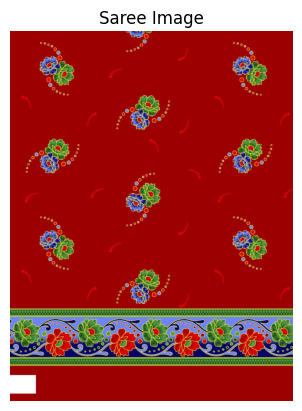


Dominant Colors and HEX Codes:
RGB: [155   0   1], HEX: #9b0001, Proportion: 77.75%
RGB: [222 206 103], HEX: #dece67, Proportion: 3.86%
RGB: [ 95 147  62], HEX: #5f933e, Proportion: 5.33%
RGB: [ 15  14 101], HEX: #0f0e65, Proportion: 2.79%
RGB: [112 130 224], HEX: #7082e0, Proportion: 3.83%
RGB: [38 83 18], HEX: #265312, Proportion: 3.44%
RGB: [204  23   8], HEX: #cc1708, Proportion: 2.53%
RGB: [253 252 251], HEX: #fdfcfb, Proportion: 0.48%


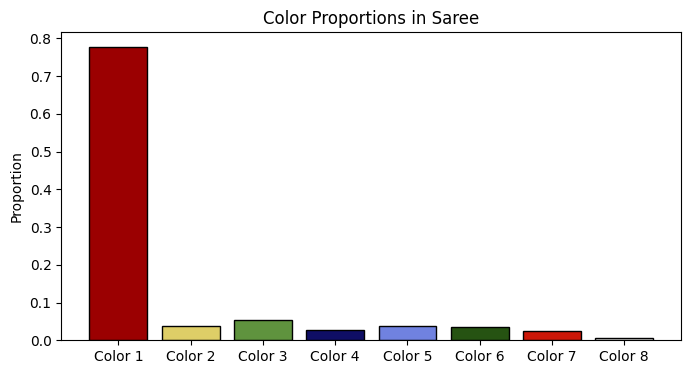

In [36]:
if __name__ == "__main__":
    main()


In [25]:
import numpy as np
import random
import json

with open("dye_detail.json", "r") as file:
    dyes = json.load(file)

# Target RGB value
target_rgb = np.array([226, 216, 150])
print(dyes)

# Extract RGB values from dyes
rgb_values = np.array([dye["rgb"] for dye in dyes])

# Genetic Algorithm Parameters
POPULATION_SIZE = 100
NUM_GENERATIONS = 250
MUTATION_RATE = 0.1
CROSSOVER_RATE = 0.7
TOURNAMENT_SIZE = 5

# Fitness function: lower is better
def fitness_function(proportions):
    mixed_rgb = np.dot(proportions, rgb_values)
    error = np.sqrt(np.sum((mixed_rgb - target_rgb) ** 2))  # Euclidean distance
    return error

# Create an initial population
def create_population(size, num_dyes):
    return np.random.dirichlet(np.ones(num_dyes), size)

# Select parents using tournament selection
def tournament_selection(population, fitness, tournament_size):
    selected_indices = random.sample(range(len(population)), tournament_size)
    best_index = min(selected_indices, key=lambda idx: fitness[idx])
    return population[best_index]

# Perform crossover between two parents
def crossover(parent1, parent2):
    if random.random() < CROSSOVER_RATE:
        crossover_point = random.randint(1, len(parent1) - 1)
        child1 = np.concatenate((parent1[:crossover_point], parent2[crossover_point:]))
        child2 = np.concatenate((parent2[:crossover_point], parent1[crossover_point:]))
        return child1, child2
    return parent1, parent2

# Perform mutation on a single individual
def mutate(individual):
    if random.random() < MUTATION_RATE:
        index = random.randint(0, len(individual) - 1)
        adjustment = np.random.uniform(-0.1, 0.1)
        individual[index] = max(0, min(1, individual[index] + adjustment))
    return individual / individual.sum()  # Ensure proportions sum to 1

# Main Genetic Algorithm
def genetic_algorithm():
    num_dyes = len(dyes)
    population = create_population(POPULATION_SIZE, num_dyes)
    best_solution = None
    best_fitness = float("inf")

    for generation in range(NUM_GENERATIONS):
        fitness = np.array([fitness_function(individual) for individual in population])
        next_population = []

        for _ in range(POPULATION_SIZE // 2):
            # Select parents
            parent1 = tournament_selection(population, fitness, TOURNAMENT_SIZE)
            parent2 = tournament_selection(population, fitness, TOURNAMENT_SIZE)

            # Crossover and mutation
            child1, child2 = crossover(parent1, parent2)
            child1 = mutate(child1)
            child2 = mutate(child2)

            next_population.extend([child1, child2])

        population = np.array(next_population)

        # Track the best solution
        current_best_idx = np.argmin(fitness)
        if fitness[current_best_idx] < best_fitness:
            best_fitness = fitness[current_best_idx]
            best_solution = population[current_best_idx]

        # Print progress
        if generation % 50 == 0 or generation == NUM_GENERATIONS - 1:
            print(f"Generation {generation}: Best Fitness = {best_fitness:.4f}")

    return best_solution, best_fitness

# Run the algorithm
best_proportions, best_error = genetic_algorithm()

# Calculate resulting RGB from optimal proportions
resulting_rgb = np.dot(best_proportions, rgb_values).round().astype(int)

# Display the results
print("\nOptimal Proportions:")
for dye, proportion in zip(dyes, best_proportions):
    if proportion > 0.01:  # Filter negligible proportions
        print(f"{dye['color']}: {proportion:.2%}")

print(f"\nBest Error (RGB Euclidean Distance): {best_error:.4f}")


[{'color': 'YELLOW 4G 200%', 'rgb': [255, 255, 102], 'price': 156.0}, {'color': 'CYANINE PINK', 'rgb': [255, 105, 180], 'price': 470.0}, {'color': 'YELLOW 5GD', 'rgb': [255, 250, 120], 'price': 210.0}, {'color': 'PINK BRF 300%', 'rgb': [255, 192, 203], 'price': 335.0}, {'color': 'YELLOW 7GE', 'rgb': [255, 220, 110], 'price': 234.0}, {'color': 'CYANINE VIOLET XF', 'rgb': [138, 43, 226], 'price': 430.0}, {'color': 'YELLOW C4G H/CONC', 'rgb': [255, 245, 115], 'price': 318.0}, {'color': 'RED VIOLET XF', 'rgb': [199, 21, 133], 'price': 735.0}, {'color': 'LUMINOUS YELLOW 10GN', 'rgb': [255, 255, 51], 'price': 628.0}, {'color': 'BRILL BLUE BG 200%', 'rgb': [0, 0, 255], 'price': 750.0}, {'color': 'YELLOW 7GD', 'rgb': [255, 230, 120], 'price': 387.0}, {'color': 'BRILL BLUE X BG', 'rgb': [0, 102, 255], 'price': 270.0}, {'color': 'YELLOW SG H/CONC', 'rgb': [255, 255, 80], 'price': 400.0}, {'color': 'BRILL BLUE BGFS 400%', 'rgb': [0, 51, 204], 'price': 2243.0}, {'color': 'BRILL. YELLOW SGL', 'rgb'

In [34]:
import numpy as np
import random
import json

with open("dye_detail.json", "r") as file:
    dyes = json.load(file)

# Target RGB value
target_rgb = np.array([152, 140, 103])

# Extract RGB values from dyes
rgb_values = np.array([dye["rgb"] for dye in dyes])

# Genetic Algorithm Parameters
POPULATION_SIZE = 100
NUM_GENERATIONS = 250
MUTATION_RATE = 0.1
CROSSOVER_RATE = 0.7
TOURNAMENT_SIZE = 5

# Fitness function: lower is better
def fitness_function(proportions):
    mixed_rgb = np.dot(proportions, rgb_values)
    error = np.sqrt(np.sum((mixed_rgb - target_rgb) ** 2))  # Euclidean distance
    return error

# Create an initial population
def create_population(size, num_dyes):
    return np.random.dirichlet(np.ones(num_dyes), size)

# Select parents using tournament selection
def tournament_selection(population, fitness, tournament_size):
    selected_indices = random.sample(range(len(population)), tournament_size)
    best_index = min(selected_indices, key=lambda idx: fitness[idx])
    return population[best_index]

# Perform crossover between two parents
def crossover(parent1, parent2):
    if random.random() < CROSSOVER_RATE:
        crossover_point = random.randint(1, len(parent1) - 1)
        child1 = np.concatenate((parent1[:crossover_point], parent2[crossover_point:]))
        child2 = np.concatenate((parent2[:crossover_point], parent1[crossover_point:]))
        return child1, child2
    return parent1, parent2

# Perform mutation on a single individual
def mutate(individual):
    if random.random() < MUTATION_RATE:
        index = random.randint(0, len(individual) - 1)
        adjustment = np.random.uniform(-0.1, 0.1)
        individual[index] = max(0, min(1, individual[index] + adjustment))
    return individual / individual.sum()  # Ensure proportions sum to 1

# Main Genetic Algorithm
def genetic_algorithm():
    num_dyes = len(dyes)
    population = create_population(POPULATION_SIZE, num_dyes)
    best_solution = None
    best_fitness = float("inf")

    for generation in range(NUM_GENERATIONS):
        fitness = np.array([fitness_function(individual) for individual in population])
        next_population = []

        for _ in range(POPULATION_SIZE // 2):
            # Select parents
            parent1 = tournament_selection(population, fitness, TOURNAMENT_SIZE)
            parent2 = tournament_selection(population, fitness, TOURNAMENT_SIZE)

            # Crossover and mutation
            child1, child2 = crossover(parent1, parent2)
            child1 = mutate(child1)
            child2 = mutate(child2)

            next_population.extend([child1, child2])

        population = np.array(next_population)

        # Track the best solution
        current_best_idx = np.argmin(fitness)
        if fitness[current_best_idx] < best_fitness:
            best_fitness = fitness[current_best_idx]
            best_solution = population[current_best_idx]

        # Print progress
        if generation % 50 == 0 or generation == NUM_GENERATIONS - 1:
            print(f"Generation {generation}: Best Fitness = {best_fitness:.4f}")

    return best_solution, best_fitness

# Run the algorithm
best_proportions, best_error = genetic_algorithm()

# Calculate resulting RGB from optimal proportions
resulting_rgb = np.dot(best_proportions, rgb_values).round().astype(int)

# Create a list of dye proportions with their details
dye_proportions = [
    {"color": dye['color'], "proportion": prop, "rgb": dye['rgb']} 
    for dye, prop in zip(dyes, best_proportions)
]

# Filter and sort proportions
significant_dyes = [
    dye for dye in dye_proportions 
    if dye['proportion'] > 0.01
]
significant_dyes.sort(key=lambda x: x['proportion'], reverse=True)

# Limit to top 3-4 dyes
top_dyes = significant_dyes[:4]

# Display the results
print("\nOptimal Proportions (Descending Order):")
for dye in top_dyes:
    print(f"{dye['color']}: {dye['proportion']:.2%}")

print(f"\nBest Error (RGB Euclidean Distance): {best_error:.4f}")
print(f"Target RGB: {target_rgb}")
print(f"Resulting RGB: {resulting_rgb}")

dyes = [
    {
        "name": dye["color"],
        "proportion": f"{dye['proportion'] * 100:.2f}%",
        "rgb": dye["rgb"]
    }
    for dye in top_dyes
]

# Print the updated dyes variable for verification
print("Updated dyes for the next program:")
for dye in dyes:
    print(dye)

Generation 0: Best Fitness = 19.8319
Generation 50: Best Fitness = 0.3188
Generation 100: Best Fitness = 0.3012
Generation 150: Best Fitness = 0.1876
Generation 200: Best Fitness = 0.0866
Generation 249: Best Fitness = 0.0263

Optimal Proportions (Descending Order):
GREEN 2B 200%: 8.44%
BRILL. YELLOW SGL: 5.21%
PRTG. YELLOW 7GN: 4.76%
YELLOW C4G H/CONC: 4.67%

Best Error (RGB Euclidean Distance): 0.0263
Target RGB: [152 140 103]
Resulting RGB: [152 140 103]
Updated dyes for the next program:
{'name': 'GREEN 2B 200%', 'proportion': '8.44%', 'rgb': [0, 255, 0]}
{'name': 'BRILL. YELLOW SGL', 'proportion': '5.21%', 'rgb': [255, 245, 90]}
{'name': 'PRTG. YELLOW 7GN', 'proportion': '4.76%', 'rgb': [255, 250, 100]}
{'name': 'YELLOW C4G H/CONC', 'proportion': '4.67%', 'rgb': [255, 245, 115]}


In [31]:
import numpy as np
import random
import json

# Load dye details
with open("dye_detail.json", "r") as file:
    dyes = json.load(file)

# Extract RGB values from dyes
rgb_values = np.array([dye["rgb"] for dye in dyes])

# Genetic Algorithm Parameters
POPULATION_SIZE = 100
NUM_GENERATIONS = 250
MUTATION_RATE = 0.1
CROSSOVER_RATE = 0.7
TOURNAMENT_SIZE = 5

# Fitness function: lower is better
def fitness_function(proportions, target_rgb):
    mixed_rgb = np.dot(proportions, rgb_values)
    error = np.sqrt(np.sum((mixed_rgb - target_rgb) ** 2))  # Euclidean distance
    return error

# Create an initial population
def create_population(size, num_dyes):
    return np.random.dirichlet(np.ones(num_dyes), size)

# Select parents using tournament selection
def tournament_selection(population, fitness, tournament_size):
    selected_indices = random.sample(range(len(population)), tournament_size)
    best_index = min(selected_indices, key=lambda idx: fitness[idx])
    return population[best_index]

# Perform crossover between two parents
def crossover(parent1, parent2):
    if random.random() < CROSSOVER_RATE:
        crossover_point = random.randint(1, len(parent1) - 1)
        child1 = np.concatenate((parent1[:crossover_point], parent2[crossover_point:]))
        child2 = np.concatenate((parent2[:crossover_point], parent1[crossover_point:]))
        return child1, child2
    return parent1, parent2

# Perform mutation on a single individual
def mutate(individual):
    if random.random() < MUTATION_RATE:
        index = random.randint(0, len(individual) - 1)
        adjustment = np.random.uniform(-0.1, 0.1)
        individual[index] = max(0, min(1, individual[index] + adjustment))
    return individual / individual.sum()  # Ensure proportions sum to 1

# Main Genetic Algorithm for a single target color
def genetic_algorithm(target_rgb):
    num_dyes = len(dyes)
    population = create_population(POPULATION_SIZE, num_dyes)
    best_solution = None
    best_fitness = float("inf")

    for generation in range(NUM_GENERATIONS):
        fitness = np.array([fitness_function(individual, target_rgb) for individual in population])
        next_population = []

        for _ in range(POPULATION_SIZE // 2):
            # Select parents
            parent1 = tournament_selection(population, fitness, TOURNAMENT_SIZE)
            parent2 = tournament_selection(population, fitness, TOURNAMENT_SIZE)

            # Crossover and mutation
            child1, child2 = crossover(parent1, parent2)
            child1 = mutate(child1)
            child2 = mutate(child2)

            next_population.extend([child1, child2])

        population = np.array(next_population)

        # Track the best solution
        current_best_idx = np.argmin(fitness)
        if fitness[current_best_idx] < best_fitness:
            best_fitness = fitness[current_best_idx]
            best_solution = population[current_best_idx]

    return best_solution, best_fitness

# Variable for extracted colors (dynamically updated from the previous program)
extracted_colors = [
    {"rgb": [56, 0, 67], "proportion": 76.91},
    {"rgb": [152, 140, 103], "proportion": 1.01},
    {"rgb": [226, 216, 150], "proportion": 5.11},
    {"rgb": [253, 250, 223], "proportion": 4.80},
    {"rgb": [118, 20, 42], "proportion": 1.75},
    {"rgb": [112, 158, 212], "proportion": 5.27},
    {"rgb": [13, 52, 105], "proportion": 3.65},
    {"rgb": [200, 43, 94], "proportion": 1.50}
]

# Extract RGB values from the dynamic input
target_colors = [color["rgb"] for color in extracted_colors]

# Loop over all target colors
results = []
for target_rgb in target_colors:
    target_rgb = np.array(target_rgb)
    best_proportions, best_error = genetic_algorithm(target_rgb)

    # Calculate resulting RGB from optimal proportions
    resulting_rgb = np.dot(best_proportions, rgb_values).round().astype(int)

    # Create a list of dye proportions with their details
    dye_proportions = [
        {"color": dye['color'], "proportion": prop, "rgb": dye['rgb']}
        for dye, prop in zip(dyes, best_proportions)
    ]

    # Filter and sort proportions
    significant_dyes = [
        dye for dye in dye_proportions
        if dye['proportion'] > 0.01
    ]
    significant_dyes.sort(key=lambda x: x['proportion'], reverse=True)

    # Store the results for this target color
    results.append({
        "target_rgb": target_rgb.tolist(),
        "best_error": best_error,
        "resulting_rgb": resulting_rgb.tolist(),
        "top_dyes": significant_dyes[:4]  # Limit to top 3-4 dyes
    })

# Display the results for all target colors
for i, result in enumerate(results):
    print(f"\nTarget Color {i + 1}:")
    print(f"Target RGB: {result['target_rgb']}")
    print(f"Resulting RGB: {result['resulting_rgb']}")
    print(f"Best Error (RGB Euclidean Distance): {result['best_error']:.4f}")
    print("Optimal Proportions (Top Dyes):")
    for dye in result["top_dyes"]:
        print(f"  {dye['color']}: {dye['proportion']:.2%}")



Target Color 1:
Target RGB: [56, 0, 67]
Resulting RGB: [56, 2, 67]
Best Error (RGB Euclidean Distance): 2.2609
Optimal Proportions (Top Dyes):
  BLACK RX-EX.CONC: 14.06%
  BLACK R PLUS: 12.87%
  BLACK CRLS 200%: 10.55%
  BRILL BLUE CB EX-CONC: 7.79%

Target Color 2:
Target RGB: [152, 140, 103]
Resulting RGB: [151, 140, 102]
Best Error (RGB Euclidean Distance): 0.0588
Optimal Proportions (Top Dyes):
  BRILL. YELLOW SGL: 7.88%
  YELLOW M-7G: 7.85%
  LUMINOUS YELLOW 10GN: 7.28%
  BRILL BLUE GRXF: 5.57%

Target Color 3:
Target RGB: [226, 216, 150]
Resulting RGB: [226, 216, 150]
Best Error (RGB Euclidean Distance): 0.0957
Optimal Proportions (Top Dyes):
  PINK BRF 300%: 23.47%
  YELLOW C4G H/CONC: 16.81%
  YELLOW 5GD: 12.82%
  YELLOW 4G 200%: 8.09%

Target Color 4:
Target RGB: [253, 250, 223]
Resulting RGB: [236, 207, 192]
Best Error (RGB Euclidean Distance): 55.5946
Optimal Proportions (Top Dyes):
  PINK BRF 300%: 75.26%
  YELLOW 5GD: 17.32%
  TURQ. BLUE SBR: 7.42%

Target Color 5:
Target

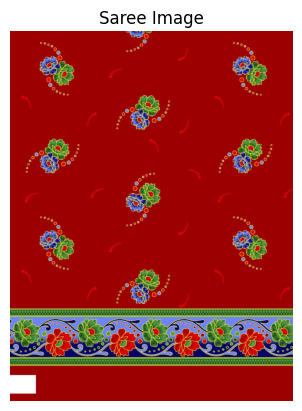


Dominant Colors and HEX Codes:
RGB: [155   0   1], HEX: #9b0001, Proportion: 77.75%
RGB: [222 206 103], HEX: #dece67, Proportion: 3.86%
RGB: [ 95 147  62], HEX: #5f933e, Proportion: 5.33%
RGB: [ 15  14 101], HEX: #0f0e65, Proportion: 2.79%
RGB: [112 130 224], HEX: #7082e0, Proportion: 3.83%
RGB: [38 83 18], HEX: #265312, Proportion: 3.44%
RGB: [204  23   8], HEX: #cc1708, Proportion: 2.53%
RGB: [253 252 251], HEX: #fdfcfb, Proportion: 0.48%


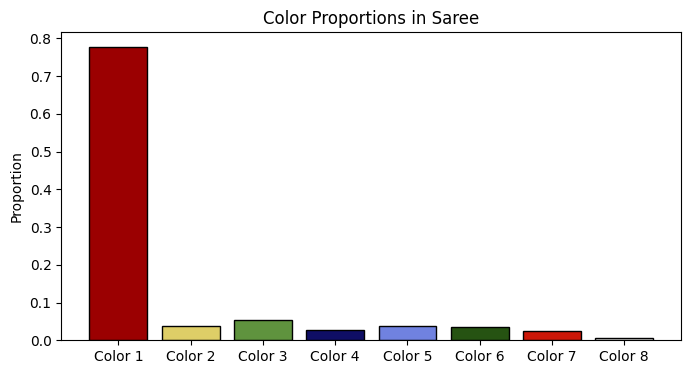


Target Color 1:
Target RGB: [155, 0, 1]
Resulting RGB: [155, 0, 1]
Best Error (RGB Euclidean Distance): 0.0616
Optimal Proportions (Top Dyes):
  LUMINOUS RED G: 14.87%
  RED 2BN 150%: 13.04%
  BRILL RED S6B: 10.75%
  RED 4B: 8.31%

Target Color 2:
Target RGB: [222, 206, 103]
Resulting RGB: [222, 206, 103]
Best Error (RGB Euclidean Distance): 0.0132
Optimal Proportions (Top Dyes):
  YELLOW SG H/CONC: 20.10%
  YELLOW 5GD: 19.04%
  YELLOW M-7G: 9.27%
  YELLOW 7GE: 8.50%

Target Color 3:
Target RGB: [95, 147, 62]
Resulting RGB: [95, 147, 62]
Best Error (RGB Euclidean Distance): 0.0307
Optimal Proportions (Top Dyes):
  GREEN 2B 200%: 17.12%
  YELLOW M-7G: 15.65%
  BLACK R LIQUID: 8.26%
  TURQ. BLUE SBR: 7.46%

Target Color 4:
Target RGB: [15, 14, 101]
Resulting RGB: [15, 14, 101]
Best Error (RGB Euclidean Distance): 0.0018
Optimal Proportions (Top Dyes):
  BRILL BLUE CB EX-CONC: 11.72%
  BLACK R PLUS: 9.54%
  BLACK 2RC: 9.54%
  NAVY BLUE 3G 200%: 9.11%

Target Color 5:
Target RGB: [112, 13

In [37]:
import numpy as np
import random
import json
from collections import Counter
from sklearn.cluster import KMeans
from matplotlib.colors import to_hex, to_rgb
import matplotlib.pyplot as plt
import cv2

# Load dye details
with open("dye_detail.json", "r") as file:
    dyes = json.load(file)

# Extract RGB values from dyes
rgb_values = np.array([dye["rgb"] for dye in dyes])

# Genetic Algorithm Parameters
POPULATION_SIZE = 100
NUM_GENERATIONS = 250
MUTATION_RATE = 0.1
CROSSOVER_RATE = 0.7
TOURNAMENT_SIZE = 5

# Fitness function: lower is better
def fitness_function(proportions, target_rgb):
    mixed_rgb = np.dot(proportions, rgb_values)
    error = np.sqrt(np.sum((mixed_rgb - target_rgb) ** 2))  # Euclidean distance
    return error

# Create an initial population
def create_population(size, num_dyes):
    return np.random.dirichlet(np.ones(num_dyes), size)

# Select parents using tournament selection
def tournament_selection(population, fitness, tournament_size):
    selected_indices = random.sample(range(len(population)), tournament_size)
    best_index = min(selected_indices, key=lambda idx: fitness[idx])
    return population[best_index]

# Perform crossover between two parents
def crossover(parent1, parent2):
    if random.random() < CROSSOVER_RATE:
        crossover_point = random.randint(1, len(parent1) - 1)
        child1 = np.concatenate((parent1[:crossover_point], parent2[crossover_point:]))
        child2 = np.concatenate((parent2[:crossover_point], parent1[crossover_point:]))
        return child1, child2
    return parent1, parent2

# Perform mutation on a single individual
def mutate(individual):
    if random.random() < MUTATION_RATE:
        index = random.randint(0, len(individual) - 1)
        adjustment = np.random.uniform(-0.1, 0.1)
        individual[index] = max(0, min(1, individual[index] + adjustment))
    return individual / individual.sum()  # Ensure proportions sum to 1

# Main Genetic Algorithm for a single target color
def genetic_algorithm(target_rgb):
    num_dyes = len(dyes)
    population = create_population(POPULATION_SIZE, num_dyes)
    best_solution = None
    best_fitness = float("inf")

    for generation in range(NUM_GENERATIONS):
        fitness = np.array([fitness_function(individual, target_rgb) for individual in population])
        next_population = []

        for _ in range(POPULATION_SIZE // 2):
            # Select parents
            parent1 = tournament_selection(population, fitness, TOURNAMENT_SIZE)
            parent2 = tournament_selection(population, fitness, TOURNAMENT_SIZE)

            # Crossover and mutation
            child1, child2 = crossover(parent1, parent2)
            child1 = mutate(child1)
            child2 = mutate(child2)

            next_population.extend([child1, child2])

        population = np.array(next_population)

        # Track the best solution
        current_best_idx = np.argmin(fitness)
        if fitness[current_best_idx] < best_fitness:
            best_fitness = fitness[current_best_idx]
            best_solution = population[current_best_idx]

    return best_solution, best_fitness

# Read and preprocess image
def read_and_preprocess_image(image_path):
    image = cv2.imread(image_path)
    if image is None:
        raise FileNotFoundError(f"Image not found at {image_path}")
    return cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Extract colors from image
def extract_colors_with_codes(image_path, num_colors):
    image = read_and_preprocess_image(image_path)
    plt.imshow(image)
    plt.title("Saree Image")
    plt.axis("off")
    plt.show()
    pixels = image.reshape((-1, 3))

    kmeans = KMeans(n_clusters=num_colors, random_state=42, n_init=10)
    kmeans.fit(pixels)

    colors = kmeans.cluster_centers_.astype(int)
    labels = kmeans.labels_

    counts = Counter(labels)
    sorted_colors = [colors[i] for i in counts.keys()]
    sorted_counts = [counts[i] for i in counts.keys()]

    hex_codes = [to_hex(np.array(color) / 255) for color in sorted_colors]

    return sorted_colors, hex_codes, sorted_counts

# Display RGB and HEX codes
def display_color_codes(colors, hex_codes, counts):
    total_pixels = sum(counts)
    print("\nDominant Colors and HEX Codes:")
    for color, hex_code, count in zip(colors, hex_codes, counts):
        proportion = count / total_pixels * 100
        print(f"RGB: {color}, HEX: {hex_code}, Proportion: {proportion:.2f}%")

# Plot color proportions
def plot_colors(colors, counts):
    total_pixels = sum(counts)
    proportions = [count / total_pixels for count in counts]

    plt.figure(figsize=(8, 4))
    for i, (color, proportion) in enumerate(zip(colors, proportions)):
        plt.bar(i, proportion, color=np.array(color) / 255, edgecolor="black")

    plt.xticks(range(len(colors)), [f"Color {i+1}" for i in range(len(colors))])
    plt.ylabel("Proportion")
    plt.title("Color Proportions in Saree")
    plt.show()

# Main function
def main():
    image_path = r'E:\VogueFusion_Pulse\design_dataset\Saree\image_4.jpg'
    num_colors = 8

    # Extract colors and display information
    colors, hex_codes, counts = extract_colors_with_codes(image_path, num_colors)
    display_color_codes(colors, hex_codes, counts)

    # Plot color proportions
    plot_colors(colors, counts)

    # Run genetic algorithm for each extracted color
    results = []
    for target_rgb in colors:
        target_rgb = np.array(target_rgb)
        best_proportions, best_error = genetic_algorithm(target_rgb)

        # Calculate resulting RGB from optimal proportions
        resulting_rgb = np.dot(best_proportions, rgb_values).round().astype(int)

        # Create a list of dye proportions with their details
        dye_proportions = [
            {"color": dye['color'], "proportion": prop, "rgb": dye['rgb']}
            for dye, prop in zip(dyes, best_proportions)
        ]

        # Filter and sort proportions
        significant_dyes = [
            dye for dye in dye_proportions
            if dye['proportion'] > 0.01
        ]
        significant_dyes.sort(key=lambda x: x['proportion'], reverse=True)

        # Store the results for this target color
        results.append({
            "target_rgb": target_rgb.tolist(),
            "best_error": best_error,
            "resulting_rgb": resulting_rgb.tolist(),
            "top_dyes": significant_dyes[:4]  # Limit to top 3-4 dyes
        })

    # Display the results for all target colors
    for i, result in enumerate(results):
        print(f"\nTarget Color {i + 1}:")
        print(f"Target RGB: {result['target_rgb']}")
        print(f"Resulting RGB: {result['resulting_rgb']}")
        print(f"Best Error (RGB Euclidean Distance): {result['best_error']:.4f}")
        print("Optimal Proportions (Top Dyes):")
        for dye in result["top_dyes"]:
            print(f"  {dye['color']}: {dye['proportion']:.2%}")

if __name__ == "__main__":
    main()


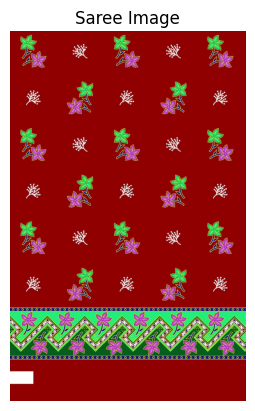


Dominant Colors and HEX Codes:
RGB: [143   0   0], HEX: #8f0000, Proportion: 77.62%
RGB: [120  60  59], HEX: #783c3b, Proportion: 2.64%
RGB: [217 214 112], HEX: #d9d670, Proportion: 4.10%
RGB: [19 94 20], HEX: #135e14, Proportion: 4.21%
RGB: [ 55 229 107], HEX: #37e56b, Proportion: 4.77%
RGB: [249 236 235], HEX: #f9eceb, Proportion: 2.25%
RGB: [191  81 193], HEX: #bf51c1, Proportion: 2.76%
RGB: [ 19  17 110], HEX: #13116e, Proportion: 1.65%


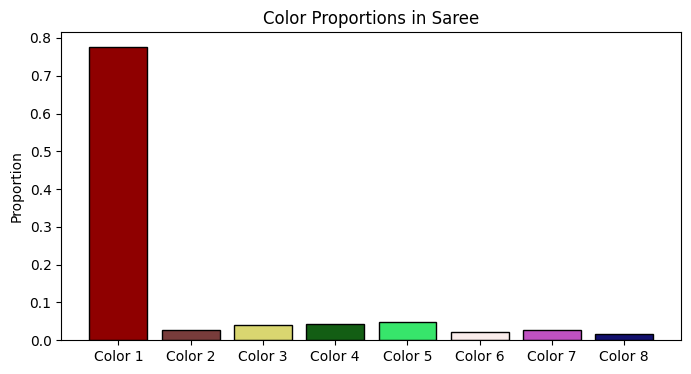


--- Dye Cost Breakdown ---
Total Dye Cost: ₹9356.81

Detailed Dye Cost Breakdown:

Color 1 (RGB: [143, 0, 0]):
  Color Dye Cost: ₹954.36
    Dye: DARK RED 2B
      Proportion: 33.73%
      Dye Price: ₹158.00/kg
      Dye Amount: 1.69 kg
      Dye Cost: ₹266.47
    Dye: RED BF 200%
      Proportion: 12.04%
      Dye Price: ₹835.00/kg
      Dye Amount: 0.60 kg
      Dye Cost: ₹502.72
    Dye: BLACK BSL H/CONC
      Proportion: 8.23%
      Dye Price: ₹234.00/kg
      Dye Amount: 0.41 kg
      Dye Cost: ₹96.35
    Dye: BLACK CRLS 200%
      Proportion: 7.37%
      Dye Price: ₹241.00/kg
      Dye Amount: 0.37 kg
      Dye Cost: ₹88.82

Color 2 (RGB: [120, 60, 59]):
  Color Dye Cost: ₹1150.78
    Dye: BLACK BSL H/CONC
      Proportion: 16.25%
      Dye Price: ₹234.00/kg
      Dye Amount: 0.81 kg
      Dye Cost: ₹190.10
    Dye: BRILL RED S6B
      Proportion: 9.58%
      Dye Price: ₹455.00/kg
      Dye Amount: 0.48 kg
      Dye Cost: ₹217.97
    Dye: SCARLET 3R 150%
      Proportion: 8.06%


In [45]:
import numpy as np
import random
import json
from collections import Counter
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import cv2

# Load dye details including prices
with open("dye_detail.json", "r") as file:
    dyes = json.load(file)

# Extract RGB values and prices from dyes
rgb_values = np.array([dye["rgb"] for dye in dyes])
dye_prices = {dye['color']: dye.get('price', 0) for dye in dyes}

# Genetic Algorithm Parameters (same as previous script)
POPULATION_SIZE = 100
NUM_GENERATIONS = 250
MUTATION_RATE = 0.1
CROSSOVER_RATE = 0.7
TOURNAMENT_SIZE = 5

# Previous functions remain the same as in the original script...
# (fitness_function, create_population, tournament_selection, 
#  crossover, mutate, genetic_algorithm, 
#  read_and_preprocess_image, extract_colors_with_codes, 
#  display_color_codes, plot_colors)

def calculate_dye_costs(results):
    """
    Calculate the total dyeing cost based on dye proportions and prices.

    Args:
    results (list): List of color matching results from genetic algorithm

    Returns:
    dict: Detailed cost breakdown
    """
    total_dye_cost = 0
    dye_cost_details = []

    # Assume standard fabric weight of 5 kg for a typical saree
    FABRIC_WEIGHT = 5  # kg

    for i, result in enumerate(results):
        color_dye_cost = 0
        color_dye_details = []

        for dye in result['top_dyes']:
            dye_name = dye['color']
            proportion = dye['proportion']

            # Get price per kg for this dye
            dye_price = dye_prices.get(dye_name, 0)

            # Calculate dye cost for this specific color
            dye_amount_weight = FABRIC_WEIGHT * proportion
            dye_cost = dye_amount_weight * dye_price

            color_dye_cost += dye_cost
            color_dye_details.append({
                'dye': dye_name,
                'proportion': proportion,
                'dye_price': dye_price,
                'dye_amount_weight': dye_amount_weight,
                'dye_cost': dye_cost
            })

        total_dye_cost += color_dye_cost
        dye_cost_details.append({
            'color_index': i + 1,
            'target_rgb': result['target_rgb'],
            'color_dye_cost': color_dye_cost,
            'dye_details': color_dye_details
        })

    return {
        'total_dye_cost': total_dye_cost,
        'dye_cost_breakdown': dye_cost_details
    }

def print_cost_breakdown(cost_breakdown):
    """
    Print a detailed cost breakdown in a readable format.

    Args:
    cost_breakdown (dict): Cost breakdown dictionary
    """
    print("\n--- Dye Cost Breakdown ---")
    print(f"Total Dye Cost: ₹{cost_breakdown['total_dye_cost']:.2f}")

    print("\nDetailed Dye Cost Breakdown:")
    for color_info in cost_breakdown['dye_cost_breakdown']:
        print(f"\nColor {color_info['color_index']} (RGB: {color_info['target_rgb']}):")
        print(f"  Color Dye Cost: ₹{color_info['color_dye_cost']:.2f}")

        for dye_detail in color_info['dye_details']:
            print(f"    Dye: {dye_detail['dye']}")
            print(f"      Proportion: {dye_detail['proportion']:.2%}")
            print(f"      Dye Price: ₹{dye_detail['dye_price']:.2f}/kg")
            print(f"      Dye Amount: {dye_detail['dye_amount_weight']:.2f} kg")
            print(f"      Dye Cost: ₹{dye_detail['dye_cost']:.2f}")

def main():
    image_path = r'E:\VogueFusion_Pulse\design_dataset\Saree\image_11.jpg'
    num_colors = 8

    # Extract colors and display information
    colors, hex_codes, counts = extract_colors_with_codes(image_path, num_colors)
    display_color_codes(colors, hex_codes, counts)

    # Plot color proportions
    plot_colors(colors, counts)

    # Run genetic algorithm for each extracted color
    results = []
    for target_rgb in colors:
        target_rgb = np.array(target_rgb)
        best_proportions, best_error = genetic_algorithm(target_rgb)

        # Calculate resulting RGB from optimal proportions
        resulting_rgb = np.dot(best_proportions, rgb_values).round().astype(int)

        # Create a list of dye proportions with their details
        dye_proportions = [
            {"color": dye['color'], "proportion": prop, "rgb": dye['rgb']}
            for dye, prop in zip(dyes, best_proportions)
        ]

        # Filter and sort proportions
        significant_dyes = [
            dye for dye in dye_proportions
            if dye['proportion'] > 0.01
        ]
        significant_dyes.sort(key=lambda x: x['proportion'], reverse=True)

        # Store the results for this target color
        results.append({
            "target_rgb": target_rgb.tolist(),
            "best_error": best_error,
            "resulting_rgb": resulting_rgb.tolist(),
            "top_dyes": significant_dyes[:4]  # Limit to top 3-4 dyes
        })

    # Calculate and print cost breakdown
    cost_breakdown = calculate_dye_costs(results)
    print_cost_breakdown(cost_breakdown)

if __name__ == "__main__":
    main()


In [46]:
import numpy as np
import random
import json
from collections import Counter
import matplotlib.pyplot as plt
import cv2

def calculate_color_proportions(image_path, num_colors=8):
    """
    Calculate more accurate color proportions using pixel counts and normalized percentages.
    
    Args:
    image_path (str): Path to the image file
    num_colors (int): Number of dominant colors to extract
    
    Returns:
    tuple: (colors, proportions, pixel_counts)
    """
    # Read the image
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    # Reshape the image to be a list of pixels
    pixels = image.reshape(-1, 3)
    
    # Use K-means for color clustering
    kmeans = KMeans(n_clusters=num_colors, random_state=42)
    kmeans.fit(pixels)
    
    # Get the colors and their pixel counts
    unique, counts = np.unique(kmeans.labels_, return_counts=True)
    
    # Calculate total pixels
    total_pixels = pixels.shape[0]
    
    # Get color proportions (percentages)
    proportions = counts / total_pixels
    
    # Get the cluster centers (representative colors)
    colors = kmeans.cluster_centers_
    
    return colors.astype(int), proportions, counts

def calculate_dye_costs(results, fabric_parameters):
    """
    Calculate a more nuanced dye cost calculation.
    
    Args:
    results (list): Color matching results
    fabric_parameters (dict): Parameters of the fabric being dyed
    
    Returns:
    dict: Detailed and more accurate cost breakdown
    """
    # Load dye details
    with open("dye_detail.json", "r") as file:
        dyes = json.load(file)
    dye_prices = {dye['color']: dye.get('price', 0) for dye in dyes}
    
    total_dye_cost = 0
    dye_cost_details = []
    
    # Fabric parameters for more accurate costing
    fabric_weight = fabric_parameters.get('weight', 5)  # kg
    base_dye_cost = fabric_parameters.get('base_dye_cost', 50)  # Fixed base cost
    
    for i, result in enumerate(results):
        color_dye_cost = base_dye_cost  # Start with a base dyeing cost
        color_dye_details = []
        color_proportion = result.get('color_proportion', 0)
        
        for dye in result['top_dyes']:
            dye_name = dye['color']
            proportion = dye['proportion']
            
            # More sophisticated cost calculation
            # Consider both dye proportion and color percentage in the image
            effective_proportion = proportion * color_proportion
            
            # Get price per kg for this dye
            dye_price = dye_prices.get(dye_name, 0)
            
            # Advanced dye amount calculation
            dye_amount_weight = fabric_weight * effective_proportion
            
            # Add complexity cost factor for precise color matching
            complexity_factor = 1 + abs(proportion - color_proportion)
            
            dye_cost = dye_amount_weight * dye_price * complexity_factor
            
            color_dye_cost += dye_cost
            color_dye_details.append({
                'dye': dye_name,
                'proportion': proportion,
                'color_proportion': color_proportion,
                'effective_proportion': effective_proportion,
                'dye_price': dye_price,
                'dye_amount_weight': dye_amount_weight,
                'complexity_factor': complexity_factor,
                'dye_cost': dye_cost
            })
        
        total_dye_cost += color_dye_cost
        dye_cost_details.append({
            'color_index': i + 1,
            'target_rgb': result['target_rgb'],
            'color_proportion': color_proportion,
            'color_dye_cost': color_dye_cost,
            'dye_details': color_dye_details
        })
    
    return {
        'total_dye_cost': total_dye_cost,
        'dye_cost_breakdown': dye_cost_details
    }

def main():
    image_path = r'E:\VogueFusion_Pulse\design_dataset\Saree\image_11.jpg'
    num_colors = 8

    # More accurate color extraction
    colors, proportions, counts = calculate_color_proportions(image_path, num_colors)
    
    # Run genetic algorithm for each extracted color
    results = []
    for target_rgb, color_proportion in zip(colors, proportions):
        # Existing genetic algorithm logic remains the same
        best_proportions, best_error = genetic_algorithm(target_rgb)

        # Resulting RGB and dye proportions
        resulting_rgb = np.dot(best_proportions, rgb_values).round().astype(int)

        dye_proportions = [
            {"color": dye['color'], "proportion": prop, "rgb": dye['rgb']}
            for dye, prop in zip(dyes, best_proportions)
        ]

        significant_dyes = [
            dye for dye in dye_proportions
            if dye['proportion'] > 0.01
        ]
        significant_dyes.sort(key=lambda x: x['proportion'], reverse=True)

        results.append({
            "target_rgb": target_rgb.tolist(),
            "color_proportion": color_proportion,  # Add color proportion
            "best_error": best_error,
            "resulting_rgb": resulting_rgb.tolist(),
            "top_dyes": significant_dyes[:4]
        })

    # More comprehensive fabric parameters
    fabric_parameters = {
        'weight': 5,  # kg
        'base_dye_cost': 50,  # Base processing cost
        'fabric_type': 'saree'
    }

    # Calculate and print cost breakdown
    cost_breakdown = calculate_dye_costs(results, fabric_parameters)
    print_cost_breakdown(cost_breakdown)

if __name__ == "__main__":
    main()

c:\Users\Samyak Varia\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)



--- Dye Cost Breakdown ---
Total Dye Cost: ₹1939.16

Detailed Dye Cost Breakdown:

Color 1 (RGB: [143, 0, 0]):
  Color Dye Cost: ₹1265.60
    Dye: DARK RED 2B
      Proportion: 39.17%
      Dye Price: ₹158.00/kg
      Dye Amount: 1.52 kg
      Dye Cost: ₹332.53
    Dye: LUMINOUS RED G
      Proportion: 9.10%
      Dye Price: ₹494.00/kg
      Dye Amount: 0.35 kg
      Dye Cost: ₹294.03
    Dye: BLACK RX-EX.CONC
      Proportion: 8.58%
      Dye Price: ₹290.00/kg
      Dye Amount: 0.33 kg
      Dye Cost: ₹163.25
    Dye: LUMINOUS RED J
      Proportion: 8.09%
      Dye Price: ₹800.00/kg
      Dye Amount: 0.31 kg
      Dye Cost: ₹425.80

Color 2 (RGB: [217, 214, 112]):
  Color Dye Cost: ₹77.17
    Dye: YELLOW C4G H/CONC
      Proportion: 19.57%
      Dye Price: ₹318.00/kg
      Dye Amount: 0.04 kg
      Dye Cost: ₹14.73
    Dye: YELLOW 5GD
      Proportion: 13.33%
      Dye Price: ₹210.00/kg
      Dye Amount: 0.03 kg
      Dye Cost: ₹6.27
    Dye: YELLOW 4GLS
      Proportion: 7.11%
    

c:\Users\Samyak Varia\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)



Extracted Colors:
Color 1: RGB [143   0   0], Hex #8f0000, Pixel Count: 1265480
Color 2: RGB [217 214 112], Hex #d9d670, Pixel Count: 66822
Color 3: RGB [19 94 20], Hex #135e14, Pixel Count: 68672
Color 4: RGB [ 55 229 107], Hex #37e56b, Pixel Count: 77835
Color 5: RGB [191  81 193], Hex #bf51c1, Pixel Count: 45062
Color 6: RGB [120  60  59], Hex #783c3b, Pixel Count: 43015
Color 7: RGB [ 19  17 110], Hex #13116e, Pixel Count: 26878
Color 8: RGB [249 236 235], Hex #f9eceb, Pixel Count: 36636


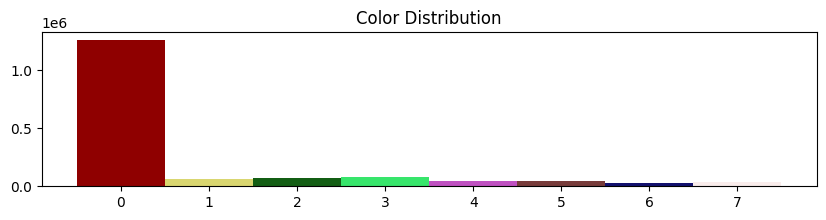


--- Dye Cost Breakdown ---
Total Dye Cost: ₹61.49

Detailed Dye Cost Breakdown:

Color 1 (RGB: [143, 0, 0]):
  Color Proportion: 77.62%
  Color Dye Cost: ₹47.56
    Dye: ORANGE RL
      Dye Proportion: 10.13%
      Color Proportion: 77.62%
      Dye Price: ₹162.00/kg
      Dye Cost: ₹7.64
    Dye: CYANINE PINK
      Dye Proportion: 8.21%
      Color Proportion: 77.62%
      Dye Price: ₹470.00/kg
      Dye Cost: ₹17.98
    Dye: BLUE ER
      Dye Proportion: 7.04%
      Color Proportion: 77.62%
      Dye Price: ₹426.00/kg
      Dye Cost: ₹13.97
    Dye: BLACK R PLUS
      Dye Proportion: 6.02%
      Color Proportion: 77.62%
      Dye Price: ₹284.00/kg
      Dye Cost: ₹7.96

Color 2 (RGB: [217, 214, 112]):
  Color Proportion: 4.10%
  Color Dye Cost: ₹2.31
    Dye: LUMINOUS RED G
      Dye Proportion: 7.87%
      Color Proportion: 4.10%
      Dye Price: ₹494.00/kg
      Dye Cost: ₹0.96
    Dye: YELLOW 7GD
      Dye Proportion: 7.19%
      Color Proportion: 4.10%
      Dye Price: ₹387.00/k

In [52]:
import numpy as np
import random
import json
from collections import Counter
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import cv2

# Load dye details including prices
with open("dye_detail.json", "r") as file:
    dyes = json.load(file)

# Extract RGB values and prices from dyes
rgb_values = np.array([dye["rgb"] for dye in dyes])
dye_prices = {dye['color']: dye.get('price', 0) for dye in dyes}

# Genetic Algorithm Parameters (same as previous script)
POPULATION_SIZE = 100
NUM_GENERATIONS = 250
MUTATION_RATE = 0.1
CROSSOVER_RATE = 0.7
TOURNAMENT_SIZE = 5

# Placeholder for previously existing functions
def fitness_function(target_rgb, proportions):
    # This function would calculate how close the mixed colors are to the target
    current_rgb = np.dot(proportions, rgb_values)
    return np.sum((current_rgb - target_rgb) ** 2)

def create_population():
    # Create initial random population of dye proportions
    population = []
    for _ in range(POPULATION_SIZE):
        proportions = np.random.dirichlet(np.ones(len(dyes)))
        population.append(proportions)
    return population

def tournament_selection(population, fitness_scores, tournament_size):
    # Select individuals for reproduction using tournament selection
    selected = []
    for _ in range(len(population)):
        tournament = random.sample(list(enumerate(population)), tournament_size)
        winner = min(tournament, key=lambda x: fitness_scores[x[0]])
        selected.append(winner[1])
    return selected

def crossover(parent1, parent2):
    # Perform crossover between two parent proportions
    alpha = np.random.random()
    child1 = alpha * parent1 + (1 - alpha) * parent2
    child2 = (1 - alpha) * parent1 + alpha * parent2
    return child1 / child1.sum(), child2 / child2.sum()

def mutate(proportions):
    # Apply small random mutations to proportions
    mutation = np.random.normal(0, MUTATION_RATE, len(proportions))
    proportions += mutation
    proportions = np.maximum(0, proportions)
    return proportions / proportions.sum()

def genetic_algorithm(target_rgb):
    # Genetic algorithm to find optimal dye proportions
    population = create_population()
    
    for _ in range(NUM_GENERATIONS):
        fitness_scores = [fitness_function(target_rgb, p) for p in population]
        
        selected = tournament_selection(population, fitness_scores, TOURNAMENT_SIZE)
        
        next_population = []
        while len(next_population) < POPULATION_SIZE:
            parent1, parent2 = random.sample(selected, 2)
            
            if random.random() < CROSSOVER_RATE:
                child1, child2 = crossover(parent1, parent2)
            else:
                child1, child2 = parent1, parent2
            
            child1 = mutate(child1)
            child2 = mutate(child2)
            
            next_population.extend([child1, child2])
        
        population = next_population[:POPULATION_SIZE]
    
    best_proportions = min(population, key=lambda p: fitness_function(target_rgb, p))
    best_error = fitness_function(target_rgb, best_proportions)
    
    return best_proportions, best_error

def read_and_preprocess_image(image_path):
    # Placeholder for image preprocessing
    return cv2.imread(image_path)

def extract_colors_with_codes(image_path, num_colors):
    # Placeholder for color extraction
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    # Reshape the image to be a list of pixels
    pixels = image.reshape(-1, 3)
    
    # Use K-means for color clustering
    kmeans = KMeans(n_clusters=num_colors, random_state=42)
    kmeans.fit(pixels)
    
    # Get the colors
    colors = kmeans.cluster_centers_
    
    # Convert to integers
    colors = colors.astype(int)
    
    # Convert to hex codes
    hex_codes = ['#%02x%02x%02x' % tuple(color) for color in colors]
    
    # Count pixel occurrences for each color
    labels = kmeans.labels_
    counts = [np.sum(labels == i) for i in range(num_colors)]
    
    return colors, hex_codes, counts

def display_color_codes(colors, hex_codes, counts):
    # Placeholder for color display
    print("\nExtracted Colors:")
    for i, (color, hex_code, count) in enumerate(zip(colors, hex_codes, counts), 1):
        print(f"Color {i}: RGB {color}, Hex {hex_code}, Pixel Count: {count}")

def plot_colors(colors, counts):
    # Placeholder for color plotting
    plt.figure(figsize=(10, 2))
    start = 0
    for color, count in zip(colors, counts):
        plt.bar(start, count, color=color/255, width=1)
        start += 1
    plt.title('Color Distribution')
    plt.show()

def calculate_dye_costs(results):
    """
    Calculate the total dyeing cost based on dye proportions and prices.

    Args:
    results (list): List of color matching results from genetic algorithm

    Returns:
    dict: Detailed cost breakdown
    """
    total_dye_cost = 0
    dye_cost_details = []

    # Assume standard fabric weight of 5 kg for a typical saree
    FABRIC_WEIGHT = 0.6  # kg

    for i, result in enumerate(results):
        # Use color proportion to scale the dye cost
        color_proportion = result.get('color_proportion', 1)
        color_dye_cost = 0
        color_dye_details = []

        for dye in result['top_dyes']:
            dye_name = dye['color']
            dye_proportion = dye['proportion']

            # Get price per kg for this dye
            dye_price = dye_prices.get(dye_name, 0)

            # Calculate dye cost considering both dye and color proportions
            dye_cost = dye_price * dye_proportion * color_proportion * FABRIC_WEIGHT

            color_dye_cost += dye_cost
            color_dye_details.append({
                'dye': dye_name,
                'dye_proportion': dye_proportion,
                'color_proportion': color_proportion,
                'dye_price': dye_price,
                'dye_cost': dye_cost
            })

        total_dye_cost += color_dye_cost
        dye_cost_details.append({
            'color_index': i + 1,
            'target_rgb': result['target_rgb'],
            'color_proportion': color_proportion,
            'color_dye_cost': color_dye_cost,
            'dye_details': color_dye_details
        })

    return {
        'total_dye_cost': total_dye_cost,
        'dye_cost_breakdown': dye_cost_details
    }


def print_cost_breakdown(cost_breakdown):
    """
    Print a detailed cost breakdown in a readable format.

    Args:
    cost_breakdown (dict): Cost breakdown dictionary
    """
    print("\n--- Dye Cost Breakdown ---")
    print(f"Total Dye Cost: ₹{cost_breakdown['total_dye_cost']:.2f}")

    print("\nDetailed Dye Cost Breakdown:")
    for color_info in cost_breakdown['dye_cost_breakdown']:
        print(f"\nColor {color_info['color_index']} (RGB: {color_info['target_rgb']}):")
        print(f"  Color Proportion: {color_info['color_proportion']:.2%}")
        print(f"  Color Dye Cost: ₹{color_info['color_dye_cost']:.2f}")

        for dye_detail in color_info['dye_details']:
            print(f"    Dye: {dye_detail['dye']}")
            print(f"      Dye Proportion: {dye_detail['dye_proportion']:.2%}")
            print(f"      Color Proportion: {dye_detail['color_proportion']:.2%}")
            print(f"      Dye Price: ₹{dye_detail['dye_price']:.2f}/kg")
            print(f"      Dye Cost: ₹{dye_detail['dye_cost']:.2f}")

def main():
    image_path = r'E:\VogueFusion_Pulse\design_dataset\Saree\image_11.jpg'
    num_colors = 8

    # Extract colors and display information
    colors, hex_codes, counts = extract_colors_with_codes(image_path, num_colors)
    
    # Calculate color proportions based on pixel counts
    total_pixels = sum(counts)
    color_proportions = [count / total_pixels for count in counts]
    
    display_color_codes(colors, hex_codes, counts)

    # Plot color proportions
    plot_colors(colors, counts)

    # Run genetic algorithm for each extracted color
    results = []
    for target_rgb, color_proportion in zip(colors, color_proportions):
        target_rgb = np.array(target_rgb)
        best_proportions, best_error = genetic_algorithm(target_rgb)

        # Calculate resulting RGB from optimal proportions
        resulting_rgb = np.dot(best_proportions, rgb_values).round().astype(int)

        # Create a list of dye proportions with their details
        dye_proportions = [
            {"color": dye['color'], "proportion": prop, "rgb": dye['rgb']}
            for dye, prop in zip(dyes, best_proportions)
        ]

        # Filter and sort proportions
        significant_dyes = [
            dye for dye in dye_proportions
            if dye['proportion'] > 0.01
        ]
        significant_dyes.sort(key=lambda x: x['proportion'], reverse=True)

        # Store the results for this target color
        results.append({
            "target_rgb": target_rgb.tolist(),
            "color_proportion": color_proportion,  # Add color proportion
            "best_error": best_error,
            "resulting_rgb": resulting_rgb.tolist(),
            "top_dyes": significant_dyes[:4]  # Limit to top 3-4 dyes
        })

    # Calculate and print cost breakdown
    cost_breakdown = calculate_dye_costs(results)
    print_cost_breakdown(cost_breakdown)


if __name__ == "__main__":
    main()